In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# figure fonts configuration
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
df_train = pd.read_csv("../data/train_set.csv")

### Grouping features
In this section, we use the knowledge coming from the data_dictionary and EDA to separate features into different groups.

In [4]:
# HLA features
feature_hla = df_train.filter(regex=("hla*")).columns.to_list()
print(len(feature_hla), feature_hla)

17 ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10']


In [5]:
# tce features
feature_tce = df_train.filter(regex="tce_*").columns.to_list()
print(len(feature_tce), feature_tce)

3 ['tce_imm_match', 'tce_match', 'tce_div_match']


In [6]:
# numerical features
df_train.select_dtypes(include=["float64","int64"]).filter(regex=("^((?!hla).)*$")).columns.to_list()

['ID',
 'year_hct',
 'donor_age',
 'age_at_hct',
 'comorbidity_score',
 'karnofsky_score',
 'efs',
 'efs_time']

In [7]:
# features contain "Yes"
df_cat = df_train.select_dtypes(include = ['O'])
feature_yes = [col for col in df_cat.columns if (df_cat[col] == "Yes").any()]
print(len(feature_yes), feature_yes)

16 ['psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_severe', 'rituximab', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate']


In [8]:
# features contain "Not done"
feature_not_done = [col for col in df_cat.columns if (df_cat[col] == "Not done").any()]
print(len(feature_not_done), feature_not_done)

13 ['psych_disturb', 'diabetes', 'arrhythmia', 'renal_issue', 'pulm_severe', 'obesity', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate']


In [9]:
# features contain "Not tested"
feature_not_test = [col for col in df_cat.columns if (df_cat[col] == "Not tested").any()]
print(len(feature_not_test), feature_not_test)

2 ['cyto_score', 'cyto_score_detail']


In [10]:
# features contain "Other"
feature_other = [col for col in df_cat.columns if (df_cat[col] == "Other").any()]
print(len(feature_other), feature_other)

1 ['cyto_score']


In [11]:
# features contain "Missing disease status"
feature_missingd = [col for col in df_cat.columns if (df_cat[col] == "Missing disease status").any()]
print(len(feature_missingd), feature_missingd)

1 ['dri_score']


In [12]:
# features contain "Non-resident of the U.S."
feature_nr = [col for col in df_cat.columns if (df_cat[col] == "Non-resident of the U.S.").any()]
print(len(feature_nr), feature_nr)

1 ['ethnicity']


In [ ]:
feature_group_dict = {
    #### #### important features (3) #### ####
    # target features (2) numeric
    "target_feature": ["efs_time", "efs"],
    # sub target (1) categorical
    "race": ["race_group"],
    
    #### #### categorical (34) #### ####
    # Yes/no diseases/symptoms/treatments (16), often takes values in ['Yes' 'No' nan 'Not done']
    "yesno": ["diabetes", 
              "obesity",
              "psych_disturb", # mental disorder
              "hepatic_severe", # liver
              "hepatic_mild", 
              "prior_tumor", # Solid tumor or not
              "peptic_ulcer", # gastric
              "rheum_issue", # joints, muscle
              "arrhythmia", # abnomral heart beats
              "cardiac",
              "renal_issue", # kidney
              "pulm_severe", # lungs or respiratory system
              "pulm_moderate",
              # These three are treatments
              "vent_hist", # History of mechanical ventilation (use a machine to assist breathing) (Ray) related to Covid
              "rituximab", # a monoclonal antibody medication
              "in_vivo_tcd", # T-cell depletion (ATG/alemtuzumab) immuno-suppressor
            ],
                  
    # tce (3) t cell epitope (surfact antigen)
    # May want to bin mismatch
    "tce":['tce_imm_match', 'tce_match', 'tce_div_match'],

    # dri and cytogenetics (3)
    "dri_cyto": ["dri_score", # disease risk index
                 "cyto_score", # chromosome abnormalities
                 "cyto_score_detail"],
                
    # graft type (2): 
    # These two features seem to be redundant
    "graft": ["graft_type", # source of stem cells
              "prod_type"], # Product type (equivalent to graft type?)

    # doner related or doner-recipient matching related (3)
    "doner":["cmv_status", # Donor/recipient CMV serostatus
             "sex_match", 
             "donor_related" #drop multiple doner?
             ],
                 
    # other recipient related categorical features (7)
    "reci": ["tbi_status", # total body irradiation
             "prim_disease_hct", # type of the leukemia
             "ethnicity", # (Ray) non-resident is treated as missing data
             "mrd_hct", # minimum residual disease, this feature is very sparse
             "gvhd_proph", # Graft-versus-Host Disease prevention
             "conditioning_intensity", # drugs for chemotherapy
             "melphalan_dose" # a chemotherapy drug (Ruibo) Might be converted to Yes/No
            ], 

    #### #### numerical features (23) #### ####

    # hla (17) numeric, human leukocyte antigen
    # May want to investigate those 0s or low percentage values
    "hla": ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 
            'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 
            'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low',
            'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low',
            'hla_match_a_low', 'hla_match_b_high', 'hla_low_res_8',
            'hla_match_drb1_high', 'hla_low_res_10'],

    # other numerical features (6)
    "other_num": ['ID',
                  'year_hct', # note that this is an integer
                  'donor_age','age_at_hct',
                  'comorbidity_score', # a risk score coming from chronic disease (0 - 10)
                  'karnofsky_score' # a measurement of a patient's ability to perform daily tasks (0 10 20 - 100)
                  ]
}

feature_clean_dict = {
    #### #### categorical features that needs to take care for data cleaning #### ####
    "Not done": ['psych_disturb', 'diabetes', 'arrhythmia', 'renal_issue', 
                 'pulm_severe', 'obesity', 'hepatic_severe', 'prior_tumor', 
                 'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 
                 'pulm_moderate'], # (13)
    "cyto_score": ["other", "Not tested"],
    "cyto_score_detail": ["Not tested"],
    "dri_score": ["Missing disease status"],
    "ethnicity": ["Non-resident of the U.S."]
}

feature_special_treat = {
    #### #### categorical features that contains values that might worth a further binning #### ####
    "tbi_status":[ 'TBI +- Other, -cGy, single','TBI +- Other, unknown dose',
                  'TBI +- Other, -cGy, unknown dose', 'TBI +- Other, -cGy, fractionated'],
    "gvhd_proph":[]
}

#### Categorical Data: Identify missing values and turn them in to 'missing'

In [14]:
df_train_cleaned = df_train.copy(deep=True)
cat_columns = df_train_cleaned.select_dtypes(include = ['O']).columns
df_train_cleaned.loc[[1,3, 30, 93, 417, 620], 'diabetes']

1            No
3           Yes
30          NaN
93          NaN
417    Not done
620    Not done
Name: diabetes, dtype: object

In [15]:
# Turning recored missing values into "missing"
null_list = ["Not done", "Not tested", "Other", "Missing disease status", "Non-resident of the U.S."]
df_train_cleaned.loc[:,cat_columns] = df_train_cleaned[cat_columns].replace(null_list, "missing")
df_train_cleaned.loc[[1,3, 30, 93, 417, 620], 'diabetes']

1           No
3          Yes
30         NaN
93         NaN
417    missing
620    missing
Name: diabetes, dtype: object

In [16]:
# Turning unrecorded missing values into a string "missing"
df_train_cleaned.loc[:,cat_columns] = df_train_cleaned[cat_columns].fillna('missing')
df_train_cleaned.loc[[1,3, 30, 93, 417, 620], 'diabetes']

1           No
3          Yes
30     missing
93     missing
417    missing
620    missing
Name: diabetes, dtype: object

In [17]:
df_train_cleaned[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   dri_score               23040 non-null  object
 1   psych_disturb           23040 non-null  object
 2   cyto_score              23040 non-null  object
 3   diabetes                23040 non-null  object
 4   tbi_status              23040 non-null  object
 5   arrhythmia              23040 non-null  object
 6   graft_type              23040 non-null  object
 7   vent_hist               23040 non-null  object
 8   renal_issue             23040 non-null  object
 9   pulm_severe             23040 non-null  object
 10  prim_disease_hct        23040 non-null  object
 11  cmv_status              23040 non-null  object
 12  tce_imm_match           23040 non-null  object
 13  rituximab               23040 non-null  object
 14  prod_type               23040 non-null  object
 15  cy

#### Numerical Data: turning missing values into -1 
HLA Human leukocyte antigens (HLA) are proteins that help identify cells as belonging to the body, and are used to match donors for hematopoietic stem cell transplants.

In [18]:
num_columns = df_train.select_dtypes(include = ['float64']).columns
num_columns

Index(['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
       'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6',
       'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low',
       'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct',
       'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score',
       'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high',
       'hla_low_res_10', 'efs', 'efs_time'],
      dtype='object')

In [19]:
df_train_cleaned.loc[:, num_columns] = df_train_cleaned[num_columns].fillna(-1.0)
df_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      23040 non-null  int64  
 1   dri_score               23040 non-null  object 
 2   psych_disturb           23040 non-null  object 
 3   cyto_score              23040 non-null  object 
 4   diabetes                23040 non-null  object 
 5   hla_match_c_high        23040 non-null  float64
 6   hla_high_res_8          23040 non-null  float64
 7   tbi_status              23040 non-null  object 
 8   arrhythmia              23040 non-null  object 
 9   hla_low_res_6           23040 non-null  float64
 10  graft_type              23040 non-null  object 
 11  vent_hist               23040 non-null  object 
 12  renal_issue             23040 non-null  object 
 13  pulm_severe             23040 non-null  object 
 14  prim_disease_hct        23040 non-null

#### Missing value analysis

In [20]:
missing_before = pd.DataFrame(df_train.isna().sum()/df_train.shape[0] * 100).reset_index() \
    .rename(columns={"index":"Feature", 0:"Percent Missing before cleaning"}) \
    .sort_values(by="Percent Missing before cleaning", ascending=False)

missing_after = pd.DataFrame(df_train_cleaned[(df_train_cleaned == -1.0) | (df_train_cleaned == 'missing')].count() / df_train_cleaned.shape[0] * 100).reset_index() \
    .rename(columns={"index":"Feature", 0:"Percent Missing after cleaning"}) \
    .sort_values(by="Percent Missing after cleaning", ascending=False)

missing = pd.concat([missing_before,missing_after],axis=1)
missing

,Feature,Percent Missing before cleaning,Feature,Percent Missing after cleaning
33,tce_match,66.032986,tce_match,66.032986
31,mrd_hct,57.773438,mrd_hct,57.773438
26,cyto_score_detail,41.362847,cyto_score_detail,41.848958
50,tce_div_match,39.648438,tce_div_match,39.648438
19,tce_imm_match,38.715278,tce_imm_match,38.715278
3,cyto_score,27.877604,cyto_score,29.843750
17,hla_high_res_10,24.822049,hla_high_res_10,24.822049
6,hla_high_res_8,20.121528,hla_high_res_8,20.121528
15,hla_high_res_6,18.255208,hla_high_res_6,18.255208
18,hla_match_dqb1_high,17.999132,hla_match_dqb1_high,17.999132


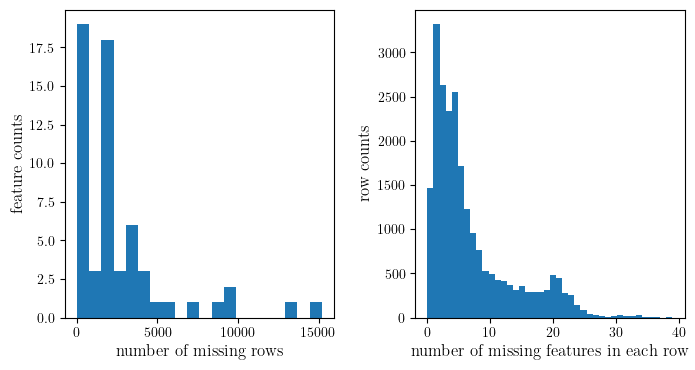

In [31]:
fig, ax = plt.subplots(figsize=(8,4), nrows = 1, ncols= 2)
plt.subplots_adjust(wspace=0.3)
ax[0].hist(df_train_cleaned[(df_train_cleaned == -1.0) | (df_train_cleaned == 'missing')].count(), bins = 20)
ax[0].set_ylabel("feature counts", fontsize=12)
ax[0].set_xlabel("number of missing rows", fontsize=12)

ax[1].hist(((df_train_cleaned == -1.0) | (df_train_cleaned == 'missing')).sum(axis = 1), bins = 40)
ax[1].set_ylabel("row counts", fontsize=12)
ax[1].set_xlabel("number of missing features in each row", fontsize=12)
plt.show()